## Importing necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
import os
from sklearn.feature_selection import SelectKBest, f_regression
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")

## Acquiring data

In [2]:
def get_zillow_data(host = host, user = user, password = password):
    filename = 'zillow.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        db = 'zillow'
        df = pd.read_sql('SELECT taxamount, yearbuilt, fips, taxvaluedollarcnt, calculatedfinishedsquarefeet, bathroomcnt, bedroomcnt, propertylandusetypeid, transactiondate FROM properties_2017 JOIN predictions_2017 USING(id) WHERE  propertylandusetypeid IN (261, 262, 263, 273, 275, 276, 279) AND transactiondate >= \'2017-05-01\' AND transactiondate <= \'2017-08-31\'', f'mysql+pymysql://{user}:{password}@{host}/{db}')
        df.to_csv(filename, index = False)
        return df


In [3]:
zillow = get_zillow_data()

## Prepping the data

In [4]:
zillow['age'] = 2021 - zillow.yearbuilt
zillow.drop(columns = ['propertylandusetypeid', 'transactiondate', 'yearbuilt'], inplace = True)
zillow.fips.replace({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'}, inplace = True)
zillow.rename(columns = {'fips': 'county'}, inplace = True)
zillow['tax_rate'] = zillow.taxamount / zillow.taxvaluedollarcnt

In [5]:
zillow.dropna(inplace = True)

In [6]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30545 entries, 0 to 31271
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   taxamount                     30545 non-null  float64
 1   county                        30545 non-null  object 
 2   taxvaluedollarcnt             30545 non-null  float64
 3   calculatedfinishedsquarefeet  30545 non-null  float64
 4   bathroomcnt                   30545 non-null  float64
 5   bedroomcnt                    30545 non-null  float64
 6   age                           30545 non-null  float64
 7   tax_rate                      30545 non-null  float64
dtypes: float64(7), object(1)
memory usage: 2.1+ MB


In [7]:
Q1 = zillow['taxvaluedollarcnt'].quantile(0.25)
Q3 = zillow['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1

zillow[zillow.taxvaluedollarcnt > (Q3 + IQR)].count()

taxamount                       2770
county                          2770
taxvaluedollarcnt               2770
calculatedfinishedsquarefeet    2770
bathroomcnt                     2770
bedroomcnt                      2770
age                             2770
tax_rate                        2770
dtype: int64

In [8]:
zillow_no_out = zillow[(zillow.taxvaluedollarcnt < (Q3 + IQR)) & (zillow.taxvaluedollarcnt > (Q1 - IQR))]

In [9]:
Q1 = zillow_no_out['tax_rate'].quantile(0.25)
Q3 = zillow_no_out['tax_rate'].quantile(0.75)
IQR = Q3 - Q1

zillow_no_out[zillow_no_out.tax_rate > (Q3 + IQR)].count()

taxamount                       3637
county                          3637
taxvaluedollarcnt               3637
calculatedfinishedsquarefeet    3637
bathroomcnt                     3637
bedroomcnt                      3637
age                             3637
tax_rate                        3637
dtype: int64

In [10]:
zillow_no_out = zillow_no_out[(zillow_no_out.tax_rate < (Q3 + IQR)) & (zillow_no_out.tax_rate > (Q1 - IQR))]

In [11]:
train, test = train_test_split(zillow_no_out, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

## Explore

In [12]:
train

,taxamount,county,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
8185,5279.42,Orange,442000.0,1116.0,2.0,3.0,61.0,0.011944
21340,2021.94,Ventura,181146.0,1184.0,2.0,4.0,65.0,0.011162
20382,4586.94,Los Angeles,367255.0,2335.0,3.0,4.0,20.0,0.012490
10958,4762.45,Los Angeles,381638.0,1342.0,2.0,3.0,67.0,0.012479
21462,3124.02,Ventura,292109.0,1281.0,2.0,3.0,42.0,0.010695
...,...,...,...,...,...,...,...,...
12507,4428.54,Los Angeles,317269.0,1670.0,3.0,4.0,41.0,0.013958
13840,3184.80,Los Angeles,252583.0,1752.0,2.0,3.0,104.0,0.012609
9138,2990.01,Los Angeles,237368.0,1630.0,2.0,3.0,64.0,0.012597
28755,3146.10,Orange,239253.0,827.0,1.0,2.0,101.0,0.013150


In [13]:
train.groupby('county').count()

,taxamount,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
county,,,,,,,
Los Angeles,8909,8909,8909,8909,8909,8909,8909
Orange,3571,3571,3571,3571,3571,3571,3571
Ventura,817,817,817,817,817,817,817


<AxesSubplot:>

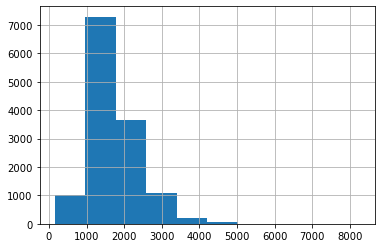

In [14]:
train.calculatedfinishedsquarefeet.hist()

<AxesSubplot:>

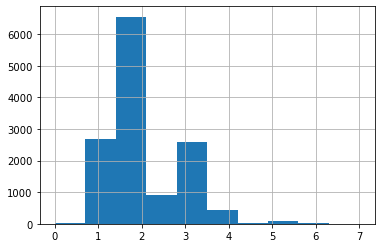

In [15]:
train.bathroomcnt.hist()

<AxesSubplot:>

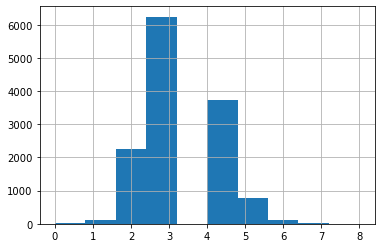

In [16]:
train.bedroomcnt.hist()

<AxesSubplot:>

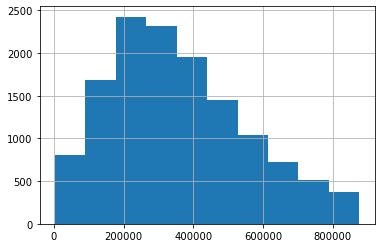

In [17]:
train.taxvaluedollarcnt.hist()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

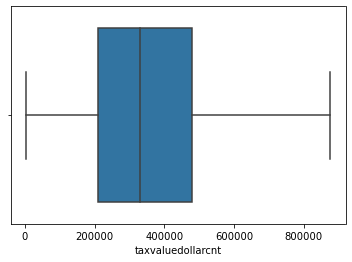

In [18]:
sns.boxplot(train.taxvaluedollarcnt)

<AxesSubplot:xlabel='bedroomcnt'>

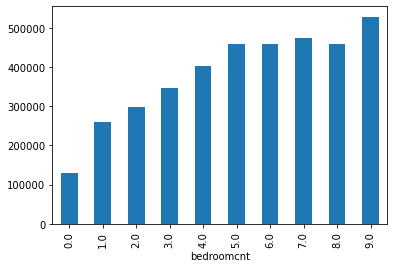

In [19]:
zillow_no_out.groupby('bedroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='bathroomcnt'>

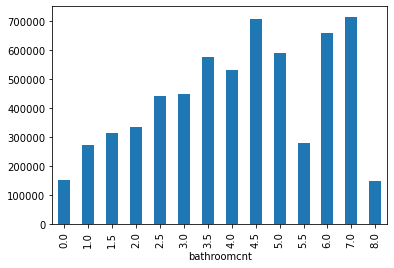

In [20]:
zillow_no_out.groupby('bathroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='taxvaluedollarcnt'>

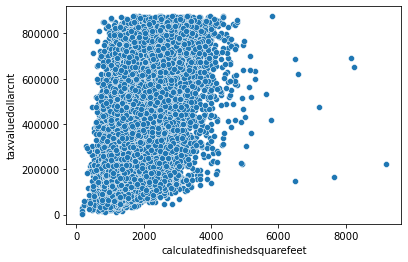

In [21]:
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'taxvaluedollarcnt', data = zillow_no_out)

<AxesSubplot:xlabel='age', ylabel='taxvaluedollarcnt'>

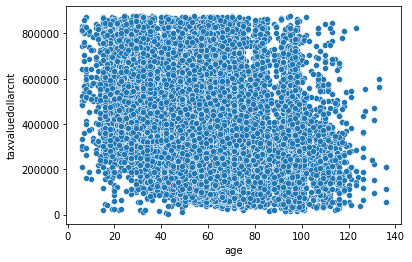

In [22]:
sns.scatterplot(x = 'age', y = 'taxvaluedollarcnt', data = zillow_no_out)

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='Count'>

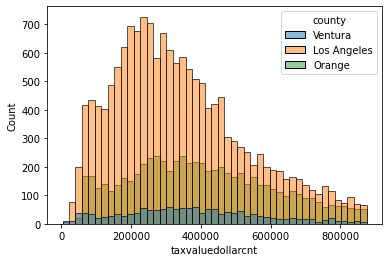

In [23]:
sns.histplot(data = zillow_no_out, x = "taxvaluedollarcnt", hue = "county")

<AxesSubplot:xlabel='county'>

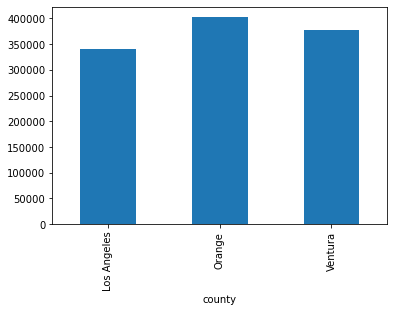

In [24]:
zillow_no_out.groupby('county').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

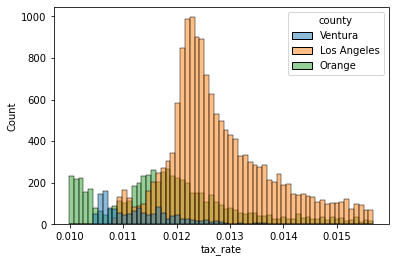

In [25]:
sns.histplot(data = zillow_no_out, x = "tax_rate", hue = "county")

<AxesSubplot:xlabel='county'>

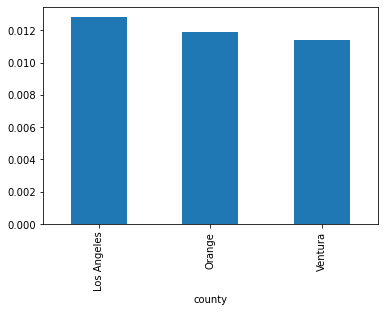

In [26]:
zillow_no_out.groupby('county').tax_rate.mean().plot.bar()

In [27]:
la_county = zillow_no_out[zillow_no_out['county'] == 'Los Angeles']
o_county = zillow_no_out[zillow_no_out['county'] == 'Orange']
vt_county = zillow_no_out[zillow_no_out['county'] == 'Ventura']
la_county.tax_rate.mean(), o_county.tax_rate.mean(), vt_county.tax_rate.mean()

(0.01282603817761915, 0.011899358158090184, 0.01141906990625272)

## Statistical tests

### Hypothesis 1

#### Null Hypothesis: There is no linear correlation between the square feet of a property and the tax value of that property

#### Alternative Hypothesis: There is a linear correlation between the square feet of a property and the tax value of that property

In [28]:
corr, p = stats.pearsonr(zillow_no_out.taxvaluedollarcnt, zillow_no_out.calculatedfinishedsquarefeet)
corr, p

(0.42807617074282955, 0.0)

#### We reject the null hypothesis that there is no linear relationship between square feet of a property and the tax value of that property.

A bigger house correlating with a higher value doesn't come as much of a surprise.

### Hypothesis 2

#### Null Hypothesis: There is no difference between Los Angeles county tax rate and the overall average county tax rates

#### Alternative Hypothesis:  There is a difference between Los Angeles county tax rate and the overall average county tax rates

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

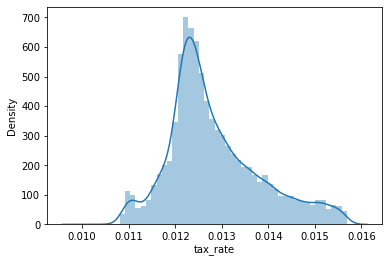

In [29]:
sns.distplot(zillow_no_out[zillow_no_out['county'] == 'Los Angeles'].tax_rate)

In [30]:
zillow_no_out.tax_rate.median(), zillow_no_out.tax_rate.mean()

(0.012369715372551637, 0.012489320456235286)

In [31]:
t, p = stats.ttest_1samp(la_county.tax_rate, zillow_no_out.tax_rate.mean())
t, p

(42.68049704419162, 0.0)

#### We reject the null hypothesis that there is no difference between Los Angeles county tax rate and the overall average county tax rates

As could have been guessed by the tax rate histogram, it seems the tax rate in Los Angeles is higher than the average tax rate.

## Modeling

### Prepping again for modeling

In [32]:
zillow_no_out.drop(columns = ['tax_rate', 'taxamount'], inplace = True)
dummies_county = pd.get_dummies(zillow_no_out[['county']], drop_first = True)
zillow_no_out.drop(columns = ['county'], inplace = True)
zillow_no_out = pd.concat([zillow_no_out, dummies_county], axis=1)

In [33]:
scaler_minmax = sklearn.preprocessing.MinMaxScaler()
scaler_minmax.fit(zillow_no_out)
zillow_minmax = scaler_minmax.transform(zillow_no_out)
zillow_minmax = pd.DataFrame(zillow_minmax)
key = zillow_no_out.columns.tolist()
zillow_minmax.rename(columns = {i: key[i] for i in range(len(key))} , inplace = True)
zillow_minmax.drop(columns = ['taxvaluedollarcnt'], inplace = True)
zillow_no_out.index = zillow_minmax.index
zillow_minmax['taxvaluedollarcnt'] = zillow['taxvaluedollarcnt']
zillow_minmax.dropna(inplace = True)

In [34]:
train, test = train_test_split(zillow_minmax, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [38]:
train.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,county_Orange,county_Ventura,taxvaluedollarcnt
4590,0.092478,0.125,0.222222,0.669231,0.0,0.0,124622.0
14678,0.224004,0.250,0.444444,0.330769,1.0,0.0,202843.0
17725,0.208960,0.375,0.555556,0.330769,0.0,0.0,260026.0
15196,0.259292,0.375,0.444444,0.223077,1.0,0.0,86917.0
1714,0.135177,0.250,0.222222,0.500000,0.0,0.0,161302.0


In [36]:
x_train = train.drop(columns = ['taxvaluedollarcnt'])
y_train = train['taxvaluedollarcnt']

x_validate = validate.drop(columns = ['taxvaluedollarcnt'])
y_validate = validate['taxvaluedollarcnt']

x_test = test.drop(columns = ['taxvaluedollarcnt'])
y_test = test['taxvaluedollarcnt']

### Establishing a baseline

In [37]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Establishing mean
zillow_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['zillow_pred_mean'] = zillow_pred_mean
y_validate['zillow_pred_mean'] = zillow_pred_mean

# Establishing median
zillow_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['zillow_pred_median'] = zillow_pred_median
y_validate['zillow_pred_median'] = zillow_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_mean)**1/2
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_mean)**1/2

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_median)**1/2
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_median)**1/2

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  178597743109.76 
Validate/Out-of-Sample:  207878702798.68
RMSE using Median
Train/In-Sample:  186867033648.94 
Validate/Out-of-Sample:  218414528125.85
